In [59]:
import numpy as np
import cupy as cp
import xgboost

RANDOM_SEED = 42

# Specify each path

In [34]:
data_directory = "../../../data/"
train_dataset = f'{data_directory}train.csv'
test_dataset = f'{data_directory}test.csv'
model_save_path = './keypoint_classifier.pkl'

# Set number of classes

In [4]:
NUM_CLASSES = 41

# Dataset reading

In [51]:
X_train = np.loadtxt(train_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 6) + 1)))
X_test = np.loadtxt(test_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 6) + 1)))

In [36]:
print(X_train[0])

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -8.2234055e-02
 -2.5042650e-01 -3.4461293e-04 -2.7820212e-01 -3.7068614e-01
 -6.8114715e-04 -4.6360445e-01 -3.6330402e-01 -9.1750070e-04
 -6.2335813e-01 -2.8670311e-01 -1.1409379e-03  1.1488125e-02
 -3.4050903e-01 -1.4199220e-03 -3.9820668e-01 -3.7492993e-01
 -1.8539312e-03 -6.3184017e-01 -3.8561359e-01 -1.9832572e-03
 -8.3974349e-01 -3.7020442e-01 -2.0369762e-03  4.1502256e-02
 -1.0069419e-01 -1.3908760e-03 -4.7585434e-01 -1.7336886e-01
 -1.8577832e-03 -7.6810634e-01 -2.2894688e-01 -1.8898296e-03
 -1.0000000e+00 -2.4808004e-01 -1.9144759e-03  1.6686631e-02
  1.0713774e-01 -1.3078672e-03 -4.5069629e-01  4.8821983e-03
 -1.6533935e-03 -3.5503414e-01 -3.1414066e-02 -1.4142469e-03
 -2.1798374e-01 -1.8832741e-02 -1.2057077e-03 -4.7681011e-02
  2.6319292e-01 -1.2418312e-03 -3.9928645e-01  1.5662472e-01
 -1.3782111e-03 -3.2068855e-01  1.1767990e-01 -1.1698863e-03
 -2.0103127e-01  1.3821097e-01 -1.0200767e-03  0.0000000e+00
  0.0000000e+00  0.00000

In [52]:
y_train = np.loadtxt(train_dataset, delimiter=',', dtype='int32', usecols=(0))
y_test = np.loadtxt(test_dataset, delimiter=',', dtype='int32', usecols=(0))

In [53]:
print(np.unique(y_train))
print(np.unique(y_test))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [54]:
X_train = np.array(X_train)
print(X_train.shape)

(14930, 126)


# Move X_train and y_train to GPU

In [61]:
print(type(X_train))


# X_train = cp.asarray(X_train)
# y_train = cp.asarray(y_train)

# print(type(X_train))

<class 'numpy.ndarray'>


# Model building

In [62]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(tree_method="hist", device="cuda")
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [45]:
best_params = grid_search.best_params_
model = XGBClassifier(**best_params)

# Model training

In [47]:
model.fit(
    X_train,
    y_train
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [49]:
# Model evaluation
# val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

model.score(X_test, y_test)

Accuracy: 0.936624203821656


0.936624203821656

# Confusion matrix

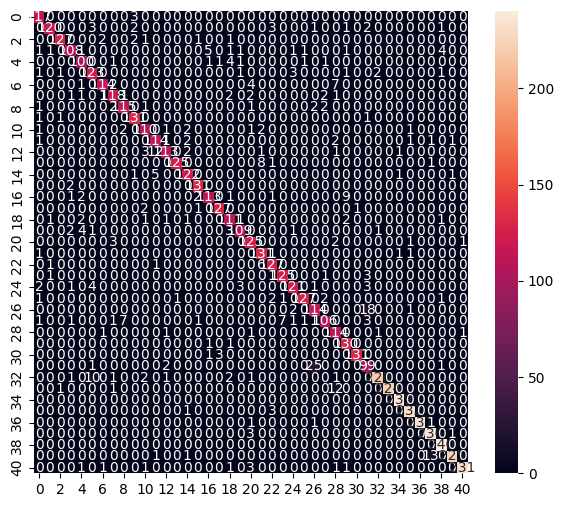

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       120
           1       0.97      0.90      0.93       133
           2       0.98      0.95      0.96       134
           3       0.92      0.86      0.89       125
           4       0.89      0.91      0.90       110
           5       0.87      0.92      0.89       133
           6       0.96      0.89      0.92       128
           7       0.91      0.91      0.91       129
           8       0.92      0.93      0.92       124
           9       0.94      0.98      0.96       134
          10       0.91      0.92      0.91       120
          11       0.86      0.93      0.89       123
          12       0.94      0.85      0.89       133
          13       0.99      0.93      0.96       135
          14       0.93      0.94      0.93       130
          15       0.96      0.98      0.97       133
          16       0.93      0.88      0.90       129
     

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, Y_pred)

# Convert to model for Tensorflow-Lite

In [14]:
import pickle

pickle.dump(model, open(model_save_path, 'wb'))

In [15]:
# Save as a model dedicated to inference
model.save_model(model_save_path)

c:\Users\o\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [22:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [16]:
loaded_model = XGBClassifier()
loaded_model.load_model(model_save_path)

In [17]:
loaded_model.score(X_test, y_test)

0.936624203821656